In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import sklearn as sk
import math

I want to load each of the CSV files in the data directory and then concatenate them into a single DataFrame.

In [2]:
import os

master_df = pd.DataFrame()
data_files = []

for filename in os.listdir("products_dataset"): # Iterates over files in the directory
    if filename.endswith(".csv"): # Check if the file ends with .csv
        data_files.append(filename) # Add the filename to the list
    else:
        continue

print(f"Found the following {len(data_files)} data files: {data_files}" )

Found the following 115 data files: ['Air Conditioners.csv', 'All Appliances.csv', 'All Car and Motorbike Products.csv', 'All Electronics.csv', 'All Exercise and Fitness.csv', 'All Grocery and Gourmet Foods.csv', 'All Home and Kitchen.csv', 'All Pet Supplies.csv', 'All Sports Fitness and Outdoors.csv', 'Amazon Fashion.csv', 'Amazon-Products.csv', 'Baby Bath Skin and Grooming.csv', 'Baby Fashion.csv', 'Baby Products.csv', 'Backpacks.csv', 'Badminton.csv', 'Bags and Luggage.csv', 'Ballerinas.csv', 'Beauty and Grooming.csv', 'Bedroom Linen.csv', 'Camera Accessories.csv', 'Cameras.csv', 'Camping and Hiking.csv', 'Car Accessories.csv', 'Car and Bike Care.csv', 'Car Electronics.csv', 'Car Parts.csv', 'Cardio Equipment.csv', 'Casual Shoes.csv', 'Clothing.csv', 'Coffee Tea and Beverages.csv', 'Cricket.csv', 'Cycling.csv', 'Diapers.csv', 'Diet and Nutrition.csv', 'Dog supplies.csv', 'Ethnic Wear.csv', 'Fashion and Silver Jewellery.csv', 'Fashion Sales and Deals.csv', 'Fashion Sandals.csv', 'Fit

Load the dataset

In [3]:
for i in data_files:
    file_path = os.path.join("products_dataset", i) # Construct the full file path for each file
    df = pd.read_csv(file_path) # Read the CSV file from the path into a DataFrame
    master_df = pd.concat([master_df, df], ignore_index=True) # Concatenate the DataFrame to the master DataFrame

master_df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,Unnamed: 0
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990",NaN
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990",NaN
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990",NaN
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990",NaN
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790",NaN


For the purposes of the task, I will be removing the category and sub-category columns as well as other columns which provide no value to the analysis.

In [4]:
master_df = master_df.drop(columns=['main_category', 'sub_category', 'image', 'link', 'Unnamed: 0']) # Drop specified columns

master_df.head()

,name,ratings,no_of_ratings,discount_price,actual_price
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,4.2,"2,255","₹32,999","₹58,990"
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,4.2,"2,948","₹46,490","₹75,990"
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,4.2,"1,206","₹34,490","₹61,990"
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,4.0,69,"₹37,990","₹68,990"
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,4.1,630,"₹34,490","₹67,790"


We want to ensure all data is empirical
We will convert the price column to flat by removing the yen symbol using regex matching

In [5]:
master_df['discount_price'] = master_df['discount_price'].replace('[\₹,]', '', regex=True).astype(float) # Convert discount_price to float
master_df['actual_price'] = master_df['actual_price'].replace('[\₹,]', '', regex=True).astype(float) # Convert actual_price to float

master_df['ratings'] = pd.to_numeric(master_df['ratings'], errors='coerce') # Convert ratings to float
master_df = master_df.dropna(subset=['ratings']) # Drop NaN values in ratings

master_df.head()

,name,ratings,no_of_ratings,discount_price,actual_price
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,4.2,"2,255",32999.0,58990.0
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,4.2,"2,948",46490.0,75990.0
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,4.2,"1,206",34490.0,61990.0
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,4.0,69,37990.0,68990.0
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,4.1,630,34490.0,67790.0


Some derived fields can be useful for analysis.
We will calculate the discount amount, the discount percentage, the price-rating ratio

In [6]:
master_df['discount'] = master_df['actual_price'] - master_df['discount_price'] # Calculate discount
master_df['discount_percentage'] = ((master_df['discount'] / master_df['actual_price']) * 100).round(2) # Calculate discount percentage
master_df['price_rating_ratio'] = (master_df['actual_price'] / master_df['ratings']).round(3) # Calculate price-rating ratio

master_df.head()

,name,ratings,no_of_ratings,discount_price,actual_price,discount,discount_percentage,price_rating_ratio
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,4.2,"2,255",32999.0,58990.0,25991.0,44.06,14045.238
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,4.2,"2,948",46490.0,75990.0,29500.0,38.82,18092.857
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,4.2,"1,206",34490.0,61990.0,27500.0,44.36,14759.524
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,4.0,69,37990.0,68990.0,31000.0,44.93,17247.500
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,4.1,630,34490.0,67790.0,33300.0,49.12,16534.146


The fatures operate on different scales, i need to standardise the data
I will use Min-Max scaling to standardise the data

In [7]:
def min_max_scaling(df, column):
    min = df[column].min() # Getting the min value in the col
    max = df[column]. max() # Getting the max value in the col

    def func(x):
        return (((x-min)/(max-min))) # Calculating min-max formula

    df[column] = df[column].apply(func) # Applying formula to all values in the column

In [8]:
scaled_df = master_df # Save my dataframe
scaled_df = scaled_df.drop(columns=['name']) # Remove non-numeric fields
scaled_df['no_of_ratings'] = scaled_df['no_of_ratings'].astype(str) # Convert object field to str
scaled_df['no_of_ratings'] = scaled_df['no_of_ratings'].replace(",", "", regex=True) # Remove commas
scaled_df['no_of_ratings'] = pd.to_numeric(scaled_df['no_of_ratings']) # Convert to numeric
scaled_df = scaled_df[scaled_df['actual_price'] <= 2000000] # Drop rows with price over 2 million as these are definite outliers


scaled_df = scaled_df.dropna() # Drop rows with missing values

scaled_df.head()

,ratings,no_of_ratings,discount_price,actual_price,discount,discount_percentage,price_rating_ratio
0,4.2,2255.0,32999.0,58990.0,25991.0,44.06,14045.238
1,4.2,2948.0,46490.0,75990.0,29500.0,38.82,18092.857
2,4.2,1206.0,34490.0,61990.0,27500.0,44.36,14759.524
3,4.0,69.0,37990.0,68990.0,31000.0,44.93,17247.500
4,4.1,630.0,34490.0,67790.0,33300.0,49.12,16534.146


In [ ]:
for column in scaled_df.columns[0:]: # Iterate over each column
    min_max_scaling(scaled_df, column) # Apply min-max to each column

scaled_df.head()

Building my K-Means++ Algorithm with a class based approach

In [10]:
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y']) # Making each data point a tuple

class Cluster: # Creating the Cluster class
    def __init__(self, label, center: Point): # Initialising values
        self.label = label
        self.center = (center.x, center.y)
        self.wcss = 0.0
        self.points_index = []

    def get_label(self):
        return self.label
    
    def get_center(self):
        return self.center
    
    def get_wcss(self):
        return self.wcss
    
    def get_points(self):
        return self.points_index

    def set_center(self, new_center):
        self.center = new_center

    def add_point(self, point):
        self.points_index.append(point)
        dx = point.x - self.center[0]
        dy = point.y - self.center[1]
        # accumulate squared distance
        self.wcss += dx*dx + dy*dy
    
    def reset_points(self):
        self.points_index = []
        self.wcss = 0.0

    def update_wcss(self, update_val):
        self.wcss = update_val

In [11]:
def k_means(dataset, clusters):
    #Assign random points as cluster centers to begin
    #Calculate distance from each center and assign to closest center
    def assign_point_to_cluster(point):
        closest_cluster = None
        current_closest_distance = float('inf')
        for cluster in clusters:
            point_cluster_distance = math.sqrt((point.y - cluster.get_center()[1])**2 + (point.x - cluster.get_center()[0])**2)
            if point_cluster_distance < current_closest_distance:
                closest_cluster = cluster
                current_closest_distance = point_cluster_distance
        closest_cluster.add_point(point)

    def recalculate_cluster_center(cluster):
        tolerance = 3
        total_x = 0
        total_y = 0
        for point in cluster.get_points():
            total_x += point.x
            total_y += point.y
        new_center = (total_x/len(cluster.get_points()), total_y/len(cluster.get_points()))
        if (new_center != cluster.get_center()) or ((new_center[0] > cluster.get_center()[0] + tolerance) and (new_center[1] > cluster.get_center()[1] + tolerance)):
            cluster.set_center(new_center)
            return True
        else:
            return False

    all_centers_unchanged = False
    cluster_change_list = []

    while not all_centers_unchanged:
        cluster_change_list = []
        for point in dataset:
            assign_point_to_cluster(point)

        for cluster in clusters:
            cluster_change_list.append(recalculate_cluster_center(cluster))
            cluster.reset_points()

        if True in cluster_change_list:
            cluster_change_list = []
        else:
            all_centers_unchanged = True

    for point in dataset:
        assign_point_to_cluster(point)

    return clusters

Now I want to find what K should be

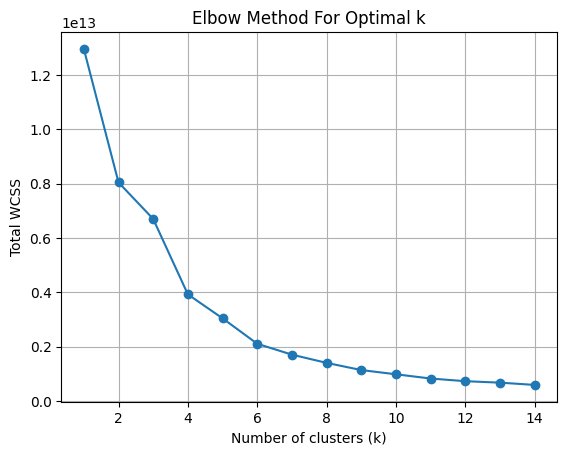

In [12]:
seed_number = 1 # This is to save my random subset for later
                # This is good practice as it means I can test my results using the same subset everytime
sample_set = scaled_df.sample(frac=0.1, random_state=seed_number) # Taking a random subset of 10% of the data

# Elbow Method

def get_total_wcss(dataset, clusters_list):
    total_wcss = 0
    clusters = k_means(dataset, clusters_list)
    for cluster in clusters:
        total_wcss += cluster.get_wcss()
    return total_wcss

from sklearn.decomposition import PCA
import random

pca = PCA(n_components=2)  # Reduce to 2D for visualization
reduced_data = pca.fit_transform(sample_set)

random.seed(2)

# Pick 15 distinct points as initial centers
initial_centers = random.sample(list(reduced_data), 15)

clusters = [
    Cluster(label=i, center=Point(x=center[0], y=center[1]))
    for i, center in enumerate(initial_centers)
]

running_total = []
for k in range(1, 15):
    centers_k = random.sample(list(reduced_data), k)
    clusters_k = [Cluster(label=i, center=Point(x=centers_k[i][0], y=centers_k[i][1])) for i in range(k)]

    wcss_k = get_total_wcss([Point(x, y) for x, y in reduced_data], clusters_k)
    running_total.append(wcss_k)

import matplotlib.pyplot as plt

plt.plot(range(1, 15), running_total, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total WCSS')
plt.grid(True)
plt.show()